### Import modules

In [33]:
import pandas as pd
import json

import datetime
import time
import numpy as np

from imblearn import under_sampling, over_sampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids, TomekLinks, OneSidedSelection, RandomUnderSampler


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, plot_roc_curve, roc_curve, auc

import seaborn as sns
import scikitplot as skplt
from matplotlib import pyplot as plt

### Loading dataset into dataframe

In [34]:
list_transactions = []
with open('transactions.txt') as fp:
    for line in fp:
        list_transactions.append(json.loads(line))

df = pd.DataFrame(list_transactions)

### Structure of the data

There are **786,363** records and **29** fields in the dataset.

In [ ]:
#number of records and fields in the dataframe
df.shape

Lets take a look at the fields of the dataset.

In [ ]:
list(df.columns)

In [ ]:
df.groupby('isFraud').mean()

### Summary statistics
Lets see a quick statistic summary of the data

In [ ]:
df.describe()

Now list the unique values for each field in the dataframe as **(fieldname, number of unique values, unique values)**

In [ ]:
for col in df:
    if col not in ['cardCVV', 'currentExpDate', 'enteredCVV']:
        print((col, df[col].nunique(), df[col].unique()))
        print()

Lets now count **null/empty values** for each of remaining fields.

In [ ]:
for col in df:
    if df[col].dtype == 'object' and df[df[col] == ''].shape[0] > 0: #fields where data type is string
        print(col, df[df[col] == ''].shape[0])
    elif df[col].isna().sum() > 0:
        print(col, df[col].isna().sum())

### Histogram of the Processed Amounts of Each Transaction

The distribution of processed amounts of transactions is **right skewed**, that means it is not symmetric around the mean. The mean is greater than the median. Also notice that the tail of the distribution on the right hand (positive) side is longer than on the left hand side.

My hypothesis is customers use credit card mostly for small transactions.

In [ ]:
sns.distplot(df['transactionAmount'], hist = True, kde = False)
plt.show()

### Duplicate Transactions

First find the total count of duplicates that resulted from **reversed transactions**.

In [ ]:
dfUniqueTransaction = df[['accountNumber', 'merchantName', 'transactionType', 'transactionAmount', 'transactionDateTime']]
dfPurchase = dfUniqueTransaction[df['transactionType'] == 'PURCHASE']
dfReversal = dfUniqueTransaction[df['transactionType'] == 'REVERSAL']

totalReversedDuplicates = 0
totalReversedDuplicatesAmount = 0

dfPurchaseSameAccount = None
prevAccountNumber = None

for _, row in dfReversal.iterrows():
    if row['accountNumber'] != prevAccountNumber:
        dfPurchaseSameAccount = dfPurchase[dfPurchase['accountNumber'] == row['accountNumber']]
        prevAccountNumber = row['accountNumber']
    if ((dfPurchaseSameAccount['transactionAmount'] == row['transactionAmount']) & (dfPurchaseSameAccount['merchantName'] == row['merchantName']) & (row['transactionDateTime'] > dfPurchaseSameAccount['transactionDateTime'])).any():
        totalReversedDuplicates += 1
        totalReversedDuplicatesAmount += row['transactionAmount']

print('Total number of reversal duplicates: ', totalReversedDuplicates)
print('Total dollar amount of reversal duplicates: $', totalReversedDuplicatesAmount)

Now we will find total count of duplicates that resulted from **multiple swipes**.

In [ ]:
dfUniqueTransaction = df[['accountNumber', 'merchantName', 'transactionType', 'transactionAmount', 'transactionDateTime']]
dfPurchase = dfUniqueTransaction[dfUniqueTransaction['transactionType'] == 'PURCHASE']
dfPurchase =dfPurchase.reset_index(drop=True)

totalMultiSwipeDuplicates = 0
totalMultiSwipeDuplicatesAmount = 0

lastSeenDuplicateTransaction = -1

for index1, row in dfPurchase.iterrows():
        
    if index1 < lastSeenDuplicateTransaction:
        continue
        
    for index2 in range(index1+1, dfPurchase.shape[0]):
        if row['accountNumber'] != dfPurchase.iloc[index2]['accountNumber']:
            break
        t1 = pd.to_datetime(row['transactionDateTime'])
        t2 = pd.to_datetime(dfPurchase.iloc[index2]['transactionDateTime'])
        
        
        if pd.Timedelta(t2 - t1).seconds > 300:
            break
                       
        if (row['merchantName'] == dfPurchase.iloc[index2]['merchantName']) and (row['transactionAmount'] == dfPurchase.iloc[index2]['transactionAmount']):
            totalMultiSwipeDuplicates += 1
            totalMultiSwipeDuplicatesAmount += row['transactionAmount']
            lastSeenDuplicateTransaction = index2    

print('Total number of multiple swipes duplicates: ', totalMultiSwipeDuplicates)
print('Total dollar amount of multiple swipes duplicates: $', totalMultiSwipeDuplicatesAmount)

Some interesting observation about the duplicate transactions:

* Five fields in the dataset were particularly important to identify both types of duplicate transactions
    * accountNumber
    * merchantName
    * transactionType
    * transactionAmount
    * transactionDateTime
    
    
* Mean value of the amount of both types of duplicate is nearly the same as mean value of total transaction amount. I can intuitively say that the duplicates do not form a distribution that is significantly different from the overall distribution of  transactions.

## Predictive Model

### Data preprocessing

Lets find the fields that has constant (same) values in all rows.

In [35]:
nunique = df.apply(pd.Series.nunique)
constantColumnNames = nunique[nunique == 1].index
constantColumnNames

Index(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip',
       'posOnPremises', 'recurringAuthInd'],
      dtype='object')

Now drop these fields from the dataframe.

In [36]:
df.drop(columns=constantColumnNames, axis=1, inplace=True)

If there are fields that are duplicates (another column exists with same value for each row), we should remove one of the duplicate columns. Below we found that **customerId** is a duplicate field.

In [37]:
duplicateColumnNames = set()
# Iterate over all the columns in dataframe
for x in range(df.shape[1]):
    # Select column at xth index.
    col = df.iloc[:, x]
    # Iterate over all the columns in DataFrame from (x+1)th index till end
    for y in range(x + 1, df.shape[1]):
        # Select column at yth index.
        otherCol = df.iloc[:, y]
        # Check if two columns at x 7 y index are equal
        if col.equals(otherCol):
            duplicateColumnNames.add(df.columns.values[y])
duplicateColumnNames = list(duplicateColumnNames)
duplicateColumnNames

['customerId']

Lets drop **customerId** field

In [38]:
df.drop(columns=duplicateColumnNames, axis=1, inplace=True)

Adding a new field **CVVmatched** that shows if entered CVV matched with original CVV

In [39]:
df['CVVmatched'] = df['enteredCVV'] == df['cardCVV']

Adding a new field **accountAge** that shows how long ago (in seconds) the account was opened until the transaction

In [40]:
df['accountAge'] = pd.to_datetime(df['transactionDateTime']) - pd.to_datetime(df['accountOpenDate'])
df['accountAge'] = df['accountAge'].dt.total_seconds()

Adding a new field **addressAge** that shows what how long (in seconds) the cardholder has been living in his last address until the transaction 

In [41]:
df['addressAge'] = pd.to_datetime(df['transactionDateTime']) - pd.to_datetime(df['dateOfLastAddressChange'])
df['addressAge'] = df['addressAge'].dt.total_seconds()

Adding new column **isMerchantCountryCode**

In [42]:
def label_race (row):
    if row['merchantCountryCode'] == '' :
        return False
    else:
        return True
#df.apply (lambda row: label_race(row), axis=1)
df['isMerchantCountryCode'] = df.apply (lambda row: label_race(row), axis=1)

In [43]:
def label_race (row):
    if row['posConditionCode'] == '' :
        return False
    else:
        return True
#df.apply (lambda row: label_race(row), axis=1)
df['isPosConditionCode'] = df.apply (lambda row: label_race(row), axis=1)

In [44]:
def label_race (row):
    if row['posEntryMode'] == '' :
        return False
    else:
        return True
#df.apply (lambda row: label_race(row), axis=1)
df['isPosEntryMode'] = df.apply (lambda row: label_race(row), axis=1)

In [45]:
def label_race (row):
    if row['merchantCategoryCode'] in ['rideshare', 'online_retail', 'online_gifts', 'airline']:
        return True
#     elif row['merchantCategoryCode'] in ['entertainment', 'fastfood', 'auto', 'food', 'furniture', 'subscriptions']:
#         return 'Medium'
    else:
        return False
#df.apply (lambda row: label_race(row), axis=1)
df['merchantCategoryRisk'] = df.apply (lambda row: label_race(row), axis=1)

In [46]:
def label_race (row):
    if row['transactionType'] == 'ADDRESS_VERIFICATION' :
        return False
    else:
        return True
#df.apply (lambda row: label_race(row), axis=1)
df['isTransactionType'] = df.apply (lambda row: label_race(row), axis=1)

### Feature Selection

From the correlation matrix below we see **creditLimit** and **availableMoney** are highly correlated.

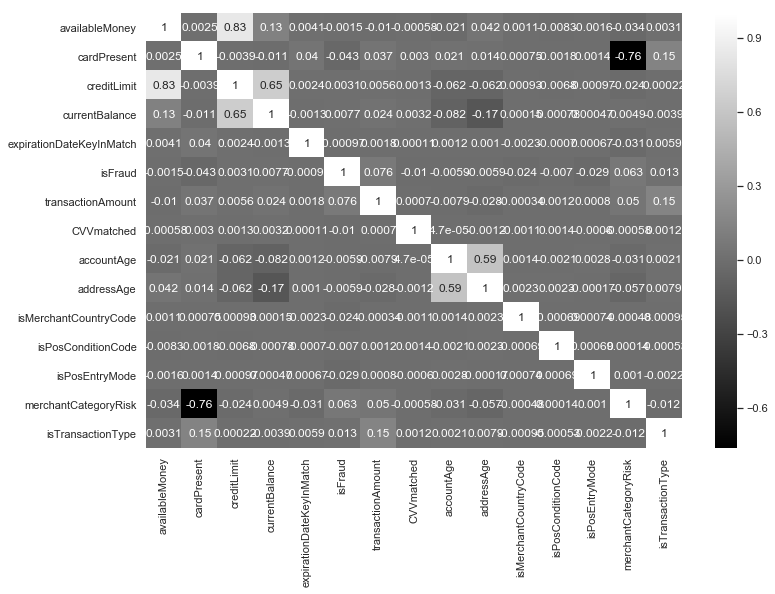

In [47]:
# corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

plt.subplots(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="gist_gray")
plt.show()

Features **creditLimit** and **availableMoney** are highly correlated (ρ = 0.834977). I will drop **creditLimit**.

In [48]:
df.drop(columns=['creditLimit'], axis=1, inplace=True)

For transactions with empty ('') **merchantCountryCode** value , below we see there is a higher ratio for a them being fraud.

Now lets remove unimportant categorical fields.

In [49]:
df.drop(columns=['currentExpDate','merchantName', 'accountOpenDate',  'cardLast4Digits',  'dateOfLastAddressChange', 'transactionDateTime', 'accountNumber', 'cardCVV', 'enteredCVV'], axis=1, inplace=True)

C:\Users\mxs7435xx\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


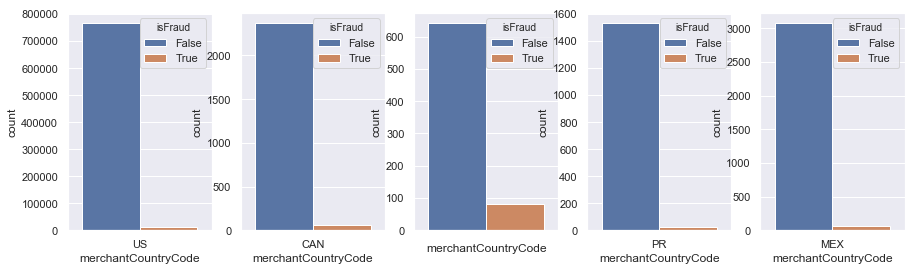

In [50]:
fig, ax = plt.subplots(1, 5)
sns.set(rc={'figure.figsize':(15, 4)})

for index, value in enumerate(df['merchantCountryCode'].unique()):
    sns.countplot(x='merchantCountryCode', hue='isFraud', data=df[df['merchantCountryCode']== value], ax=ax[index])
fig.show()

C:\Users\mxs7435xx\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


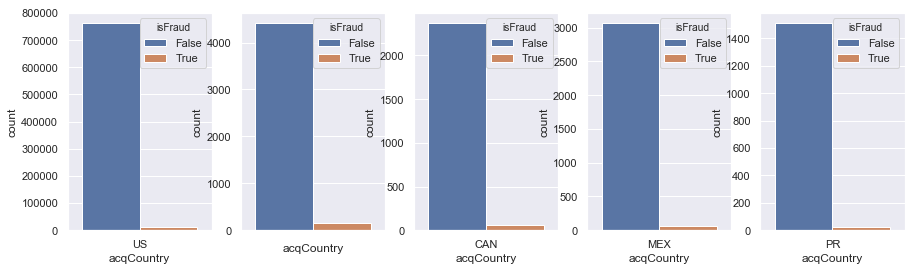

In [51]:
col = 'acqCountry'

fig, ax = plt.subplots(1, df[col].nunique())
sns.set(rc={'figure.figsize':(15, 4)})

for index, value in enumerate(df[col].unique()):
    sns.countplot(x=col, hue='isFraud', data=df[df[col]== value], ax=ax[index])
fig.show()

In [52]:
print(df.columns)

Index(['acqCountry', 'availableMoney', 'cardPresent', 'currentBalance',
       'expirationDateKeyInMatch', 'isFraud', 'merchantCategoryCode',
       'merchantCountryCode', 'posConditionCode', 'posEntryMode',
       'transactionAmount', 'transactionType', 'CVVmatched', 'accountAge',
       'addressAge', 'isMerchantCountryCode', 'isPosConditionCode',
       'isPosEntryMode', 'merchantCategoryRisk', 'isTransactionType'],
      dtype='object')


In [53]:
df_temp = df
dum_df = pd.get_dummies(df_temp, columns=[ ])
df_temp = dum_df

In [54]:
y = df_temp[['isFraud']]
X = df_temp.drop(columns=['acqCountry','transactionType', 'posConditionCode', 'merchantCountryCode',  'isFraud', 'posEntryMode' , 'merchantCategoryCode'], axis=1)

X.columns

Index(['availableMoney', 'cardPresent', 'currentBalance',
       'expirationDateKeyInMatch', 'transactionAmount', 'CVVmatched',
       'accountAge', 'addressAge', 'isMerchantCountryCode',
       'isPosConditionCode', 'isPosEntryMode', 'merchantCategoryRisk',
       'isTransactionType'],
      dtype='object')

### Class Imbalance

From the plot below it's clear that the dataset is **highly imbalanced**.

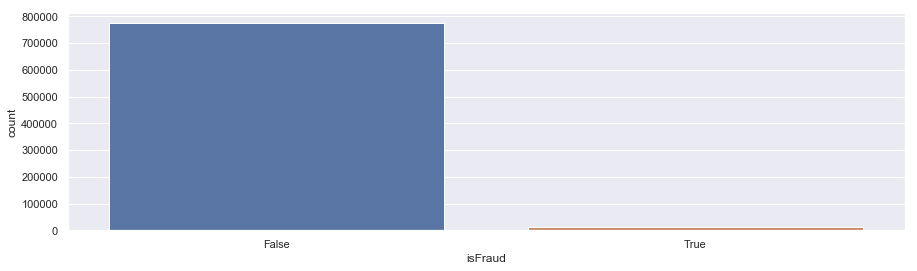

In [55]:
sns.countplot(x='isFraud', data = df)
plt.show()

Lets first scale the value of data.

In [56]:
scaled_features = StandardScaler().fit_transform(X.values)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

We will now re-sample the dataset to get a balanced training data.

In [57]:
def resampling(X, y):
    # define pipeline
    over = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.4)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    #X, y = pipeline.fit_resample(X, y)
    return pipeline.fit_resample(X, y)

### Logistic Regression Model

In [58]:
def model(X_train, X_test, y_train, y_test):
    

    start = time.time()
    clf = LogisticRegression(penalty='l2', solver='saga', class_weight='balanced',
                                          tol=1e-3, max_iter=1000000,
                                          warm_start=True, random_state=42,
                                          intercept_scaling=1000)

    # clf = LogisticRegression()
    clf.fit(X_train , np.ravel(y_train))
    #print("Intercept: " , clf.intercept_)
    #print("Coefficients: " , clf.coef_)
    return clf.predict(X_test)
    

In [59]:
#X_train.columns

### Validation

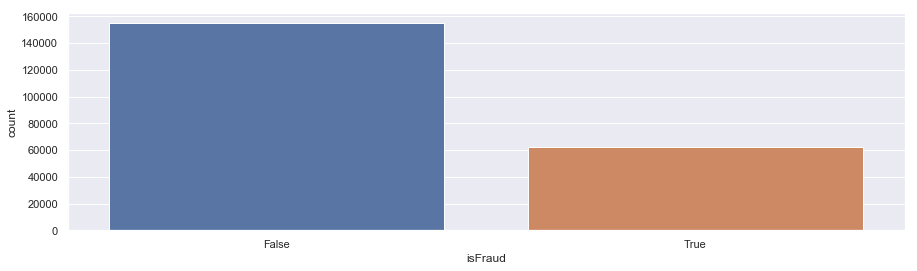

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, y_train = resampling(X_train, y_train)

sns.countplot(x='isFraud', data = X_train.join(y_train))
plt.show()

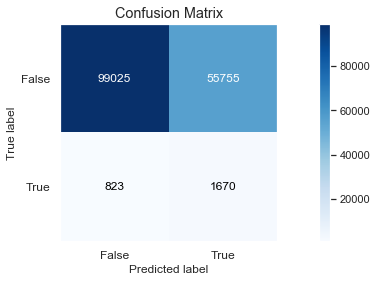

In [61]:
predict =  model(X_train, X_test, y_train, y_test)

skplt.metrics.plot_confusion_matrix(y_test, predict)

In [62]:
print(accuracy_score(y_test, predict))

0.6402561151628061


### ROC Curve

Text(0.5, 0, 'False positive rate')

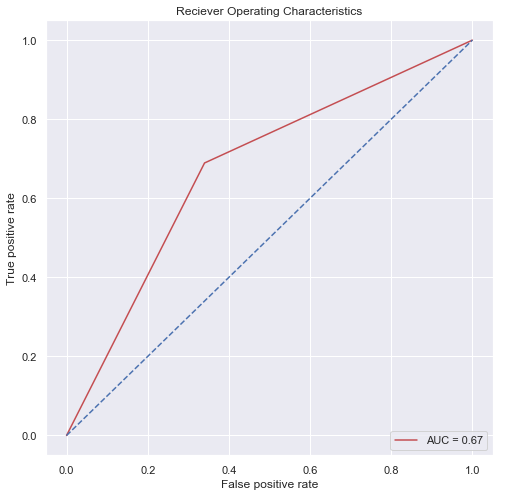

In [66]:
frp,trp, threshold = roc_curve(y_test, predict)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(8,8))
plt.title('Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

### K-fold Cross Validation

In [64]:
kf = KFold(n_splits=10)
auc_scores = []

k = 1

for train_index, test_index in kf.split(X):
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
    
    X_train, y_train = resampling(X_train, y_train)
    predict = model(X_train, X_test, y_train, y_test)
    
    auc_score = roc_auc_score(y_test, predict)
    print('AUC score for fold #'+str(k)+' : ', auc_score)
    auc_scores.append(auc_score)
    k+= 1

print("Mean AUC score: ", sum(auc_scores)/len(auc_scores))

AUC score for fold #1 :  0.5963126381690388
AUC score for fold #2 :  0.6613998494594865
AUC score for fold #3 :  0.6946469171057819
AUC score for fold #4 :  0.6594304299709847
AUC score for fold #5 :  0.6477790617981842
AUC score for fold #6 :  0.6999262128919994
AUC score for fold #7 :  0.6077130853867757
AUC score for fold #8 :  0.670316736270966
AUC score for fold #9 :  0.6211309946017342
AUC score for fold #10 :  0.6746163048607794
Mean AUC score:  0.653327223051573
